In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#set figure size
plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('white')

# others
from random import randrange
from time import time

import pickle
import gzip

from keras.datasets import mnist

Define the number of epochs globally, also number of epochs for cross validation when using gridsearch 

In [2]:
n_epochs = 30
n_epochs_cv = 10 

n_cv = 3
validation_ratio = 0.10


## 1. Data exploration
We load the data and display some sample observations to understand the data structure.  

In [3]:
# load dataset and check dimension
data_set = pd.read_csv('train.csv')
print(data_set.shape)

(42000, 785)


In [4]:
# data_set.sample(3)

We check the distribution of the 10 classes of digits. They are roughly equivalently represented, therefore we do not need to use stratify when splitting the data set into training and validation sets.

/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


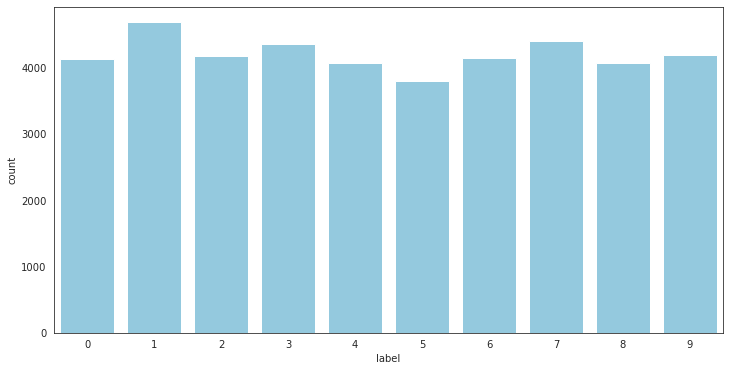

In [5]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

Next, let's plot a random sample of 60 images to get a *visual feeling* of the classification task. 

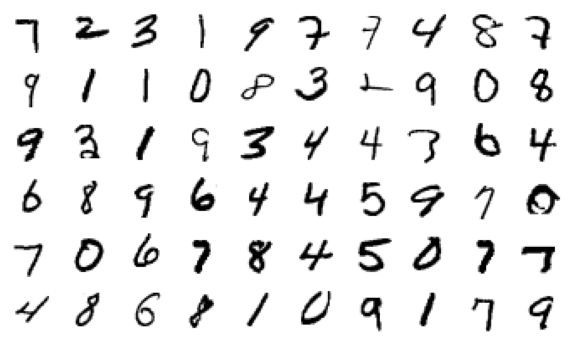

In [6]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(6, 10, figsize=(10, 6)) # 6 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [7]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = validation_ratio)

## 2. Implementing a simple MLP
Let's start with a simple multilayer perceptron with only 1 hidden layer:
* the input layer consists in 128 units, with relu
* the hidden layer is made of 64 units, with sigmoid activation function
* the output layer contains one unit per expected class, that is 10 units, and uses a softmax activation function to output probabilities  
[](http://)
How many parameters has this model?
* the input layer is taking values from 28x28 images: the number of parameters is 28x28 (input size) x 128 (output size) weights + 128 bias values = 100,480
* for the hidden layer, a similar caculation gives 128 x 64 + 64 = 8,256
* and for the output layer, we have 64 x 10 + 10 = 650 parameters  

OK, this was easy, but we'll see below that counting parameters of CNN is a bit more tricky. 

In [8]:

mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


# 1. Early stopping as callback to reduce the training time 
Look at the accuracy on the validation set and compare it with the accuracy on the training set. What can you say about the performance and limits of this simple model?

In [9]:

early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Epoch 1/30
1182/1182 [==============================] - 2s 1ms/step - loss: 0.3927 - accuracy: 0.8976 - val_loss: 0.1801 - val_accuracy: 0.9502
Epoch 2/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.1462 - accuracy: 0.9565 - val_loss: 0.1303 - val_accuracy: 0.9631
Epoch 3/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0984 - accuracy: 0.9703 - val_loss: 0.1174 - val_accuracy: 0.9631
Epoch 4/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0720 - accuracy: 0.9780 - val_loss: 0.0998 - val_accuracy: 0.9702
Epoch 5/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0536 - accuracy: 0.9839 - val_loss: 0.0900 - val_accuracy: 0.9731
Epoch 6/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.0871 - val_accuracy: 0.9729
Epoch 7/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 0.0898 - val_accuracy:

# Comment 
* the performance of our model is given by the best accuracy obtained on the validation set: around 0.975 (depending on the run)
* the best scores are already obtained after more or less 10 epochs, meaning that there is probably no or little gain to increase number of epochs
* and there is clear sign of overfitting as the loss for the validation set (around 0.1) is roughly 10 times the loss on the training set (around 0.01).  

Let's plot the accuracy for the training and validation to confirm this last point.  

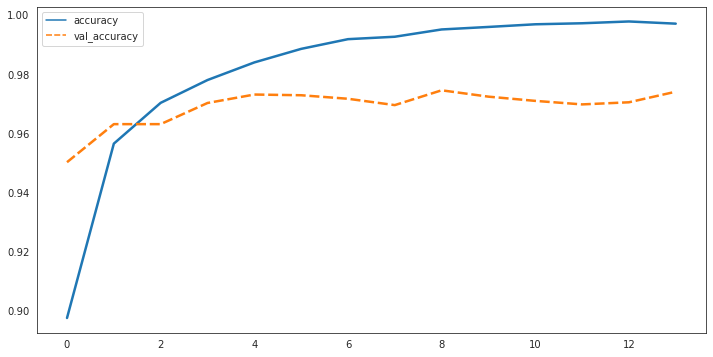

In [10]:
# compare accuracy accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

## 3. DROPOUT
The dropout rate will be determined thru a grid search, along with the batch size.  
For this, we will use the KerasClassifier wrapper for Scikit Learn, which gives us a Scikit Learn estimator that we can optimize with GridSearchCV (cf Keras [documentation](https://keras.io/scikit-learn-api/)).  

Results are:
* no more overfit from dropout rate = 0.2 and above 
* no or minimal improvement of the accuracy on the validation set: **we are reaching the limit of a simple MLP model**
* noticeable degradation of results (both on training and validation sets) for rate of 0.4 and above 

In [11]:
start=time()

def create_mlp_model(dropout_rate=0):
    # create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,))) 
    # add a dropout layer if rate is not null
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))        
    model.add(Dense(64, activation='sigmoid')) 
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))           
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    
    
# create model
model = KerasClassifier(build_fn=create_mlp_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X, to_categorical(y))  # fit the full dataset as we are using cross validation 

# print out results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

<ipython-input-11-146e172bb782>:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_mlp_model, verbose=1)


Epoch 1/10
2625/2625 [==============================] - 3s 968us/step - loss: 0.3501 - accuracy: 0.9030
Epoch 2/10
2625/2625 [==============================] - 2s 910us/step - loss: 0.1413 - accuracy: 0.9574
Epoch 3/10
2625/2625 [==============================] - 2s 905us/step - loss: 0.1023 - accuracy: 0.9688
Epoch 4/10
2625/2625 [==============================] - 2s 901us/step - loss: 0.0835 - accuracy: 0.9742
Epoch 5/10
2625/2625 [==============================] - 2s 897us/step - loss: 0.0667 - accuracy: 0.9799
Epoch 6/10
2625/2625 [==============================] - 2s 908us/step - loss: 0.0586 - accuracy: 0.9817
Epoch 7/10
2625/2625 [==============================] - 2s 899us/step - loss: 0.0503 - accuracy: 0.9838
Epoch 8/10
2625/2625 [==============================] - 2s 906us/step - loss: 0.0443 - accuracy: 0.9855
Epoch 9/10
2625/2625 [==============================] - 2s 910us/step - loss: 0.0388 - accuracy: 0.9873
Epoch 10/10
2625/2625 [==============================] - 2s 921u

The best score (around 0.973) is obtained for a drop out rate of 0.10 and a batch size of 16 or 32 (depending on the run).  
Looking at the mean accuracy for each set of parameters:
* batch sizes of 16 or 32 give similar results, but we see a degradation for batch size = 64
* droprout rate of 0.10 consistently gives better results, regardless of the batch size

 best score is lower than the accuracy that we obtained before without hyperparameter optimization (!?). 
 
 __Reason__ the best score value is an average of the score of the best estimator over all epochs (I'd appreciate a lot if someone can point me to the exact reason). For this reason, I reload the best estimator and train it on the full dataset. Compared to the first network that we trained, there is a slight improvement of the accuracy at 0.978. I dont get the reason too!!

In [12]:
# reload best model
mlp = grid_result.best_estimator_ 

# retrain best model on the full training set 
history = mlp.fit(
    X_train,
    to_categorical(y_train),
    validation_data = (X_val, to_categorical(y_val)),
    epochs = n_epochs,
    callbacks = [early_stop]    
)

Epoch 1/30
2363/2363 [==============================] - 4s 1ms/step - loss: 0.3807 - accuracy: 0.8942 - val_loss: 0.1603 - val_accuracy: 0.9536
Epoch 2/30
2363/2363 [==============================] - 2s 981us/step - loss: 0.1533 - accuracy: 0.9546 - val_loss: 0.1221 - val_accuracy: 0.9638
Epoch 3/30
2363/2363 [==============================] - 2s 995us/step - loss: 0.1106 - accuracy: 0.9660 - val_loss: 0.1027 - val_accuracy: 0.9688
Epoch 4/30
2363/2363 [==============================] - 2s 1000us/step - loss: 0.0850 - accuracy: 0.9742 - val_loss: 0.0960 - val_accuracy: 0.9729
Epoch 5/30
2363/2363 [==============================] - 2s 1ms/step - loss: 0.0712 - accuracy: 0.9769 - val_loss: 0.0887 - val_accuracy: 0.9740
Epoch 6/30
2363/2363 [==============================] - 2s 1ms/step - loss: 0.0587 - accuracy: 0.9807 - val_loss: 0.0860 - val_accuracy: 0.9750
Epoch 7/30
2363/2363 [==============================] - 2s 999us/step - loss: 0.0517 - accuracy: 0.9831 - val_loss: 0.0908 - val_

132/132 [==============================] - 1s 524us/step
Accuracy on validation data = 0.9790


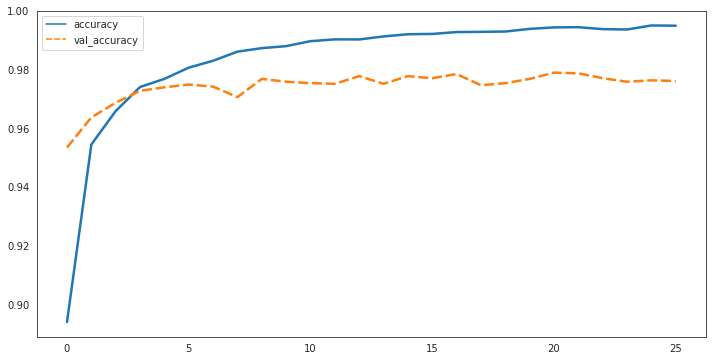

In [13]:
# get prediction on validation dataset 
y_pred = mlp.predict(X_val)
print('Accuracy on validation data = {:.4f}'.format(accuracy_score(y_val, y_pred)))

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [14]:
# load test data and make prediction
test = pd.read_csv('test.csv')
y_test = mlp.predict(test)

875/875 [==============================] - 0s 496us/step


## 4. Implementing a Convolutional Neural Network
We implement now a CNN since MLP model is limited at 0.975 accuracy. I selected the architecture thru trials based on several examples. 

In [15]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size = validation_ratio)

(42000, 28, 28, 1)


In [16]:
# function to create the model for Keras wrapper to scikit learn
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers 
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) 
        
    # second series of layers: convolution, pooling, and dropout
    model.add(Conv2D(32, kernel_size=(5, 5), activation=conv_activation))  
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
    
    # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   # 32   
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
      
    # fourth series
    model.add(Flatten())         
    model.add(Dense(64, activation='sigmoid')) # 64
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

cnn = create_cnn_model()

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                  

Let's check the number of parameters:
* the first layer is a convolution layer with 16 kernels of size 5x5. Each kernel has 26 parameters (25 weigths plus bias). Total is 16 x 26 = 416
* the second layer is also a convolution layer with 32 kernels of size 5x5. There are 16 input images from the output of the previous layer. For every kernel, the 16 images are combined together, with 16 (input size) x 25 (kernel size) weights plus bias (that is 401 parameters for each kernel). Total number of parameters for this layers is 401 x 32 = 12,832
* using same calculation logic, the number of parameters for the 3rd layer is ( 32 (input size) x 9 (kernel size) + 1 ) x 64 (number of kernels) = 18,4896
* for the dense layer, its input is the result of the flatten layer (taking as input the 64 x 16 images from the pooling layer, and mapping them to a flat array of 64 x 16 = 1024). Output size is 64, therefore number of parameters is 64 x (1024 weights + bias) = 65,600
* same way, the final layer has (64 x 1) x 10 = 650 parameters

In [17]:
# Train the default CNN model
history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=32,
    callbacks = [early_stop]
)

Epoch 1/30
1182/1182 [==============================] - 17s 14ms/step - loss: 0.4887 - accuracy: 0.8597 - val_loss: 0.1200 - val_accuracy: 0.9669
Epoch 2/30
1182/1182 [==============================] - 16s 14ms/step - loss: 0.1046 - accuracy: 0.9702 - val_loss: 0.0823 - val_accuracy: 0.9755
Epoch 3/30
1182/1182 [==============================] - 16s 14ms/step - loss: 0.0726 - accuracy: 0.9794 - val_loss: 0.0664 - val_accuracy: 0.9824
Epoch 4/30
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.0544 - val_accuracy: 0.9838
Epoch 5/30
1182/1182 [==============================] - 16s 14ms/step - loss: 0.0463 - accuracy: 0.9859 - val_loss: 0.0582 - val_accuracy: 0.9826
Epoch 6/30
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0402 - accuracy: 0.9879 - val_loss: 0.0508 - val_accuracy: 0.9852
Epoch 7/30
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0346 - accuracy: 0.9894 - val_loss: 0.0496 -

We gained about 1% of accuracy with the CNN! But there is a cost: training the CNN model takes 45 seconds per epoch, about 10 times what the MLP  required!  
Let's optimize now some hyperparameters (pooling type and activation function) to further improve the performance of this CNN. 

## 5. Optimize the hyperparameters of the CNN thru GridSearch

In [ ]:
# optimize model 
start = time()

# create model
model = KerasClassifier(build_fn=create_cnn_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['sigmoid', 'tanh'],    
    'epochs': [n_epochs_cv],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X_train, to_categorical(y_train))

# summarize results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

<ipython-input-18-22ede9560e86>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_model, verbose=1)


## 6. Use data augmentation to improve performance (BONUS)

In [ ]:
# optimize parameters of the fit method 
cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'])

# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='constant', cval = 0.0)

datagen.fit(X_train)

history = cnn_model.fit_generator(datagen.flow(X_train,to_categorical(y_train), batch_size=32),
                                  epochs = n_epochs, 
                                  validation_data = (X_val,to_categorical(y_val)),
                                  verbose = 1, 
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks = [early_stop])

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

The accuracy on the validation is consistently higher than on the training set. The model is too much constrained: let's retrain it with data augmentation but without dropout and see how it performs. 

In [ ]:
# optimize parameters of the fit method 
cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'], 
                            dropout_rate=0.0)

#define early stop on the accuracy as this is the metric we want to improve
early_stop = EarlyStopping(monitor = 'accuracy', mode = 'max', patience=5, restore_best_weights=True)
history = cnn_model.fit_generator(datagen.flow(X_train,to_categorical(y_train), batch_size=32),
                                  epochs = n_epochs, 
                                  validation_data = (X_val,to_categorical(y_val)),
                                  verbose = 1, 
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks = [early_stop])

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [ ]:
# save weights
cnn_model.save_weights('mnist_cnn.h5')
test = pd.read_csv('test.csv')

X_test = test.values.reshape(-1, img_size, img_size, 1)
y_test = cnn_model.predict(X_test)

# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('submission-cnn.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)